## Imports

In [2]:
import eduanalytics
from eduanalytics import model_data, pipeline_tools, reporting

In [3]:
import re, os, sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

## Explore results

In [4]:
path = eduanalytics.credentials_path
group = eduanalytics.credentials_group

engine = model_data.connect_to_database(path, group)

In [42]:
tbl_name = 'residency_noncompete_admissions'

In [43]:
results = model_data.get_data_for_modeling(engine, 
            tbl_name, status = 'predictions')

In [44]:
train = results[results.set == 'train']
test = results[results.set == 'test']

In [45]:
print(train.outcome.value_counts())
print(train.shape)

0.0    981
1.0    107
Name: outcome, dtype: int64
(1088, 4)


In [46]:
print(test.outcome.value_counts())
print(test.shape)

0.0    213
1.0     12
Name: outcome, dtype: int64
(225, 4)


In [47]:
pkl_path = '/Volumes/IIME/EDS/data/admissions/pkls'

In [48]:
grid_search = reporting.load_model(pkl_path, tbl_name, 'rf_grid')

In [49]:
grid_search

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('dummyencoder', DummyEncoder()), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=N...imators=10, n_jobs=1, oob_score=False, random_state=1100,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'imputer__strategy': ['mean', 'median'], 'randomforestclassifier__n_estimators': [10, 50, 100, 200, 500, 1000], 'randomforestclassifier__max_depth': [1, 5, 10, 20, 50], 'randomforestclassifier__max_features': ['sqrt', 'log2'], 'randomforestclassifier__min_samples_split': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [50]:
risk_scores = test.predicted
hard_predictions = [1 if score >= 0.5 else 0 for score in risk_scores]

In [25]:
percentages = [15, 20]
hard_predictions_t1 = reporting.generate_binary_at_k(risk_scores, percentages[0])
hard_predictions_t2 = reporting.generate_binary_at_k(risk_scores, percentages[1])

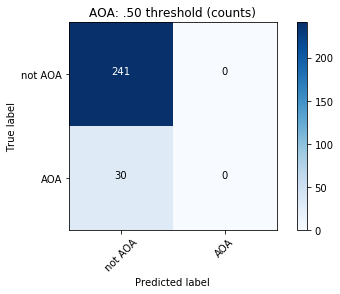

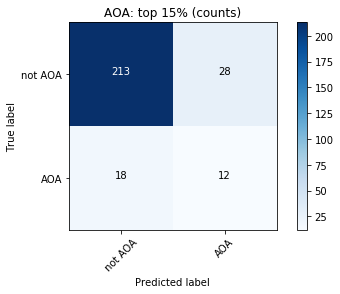

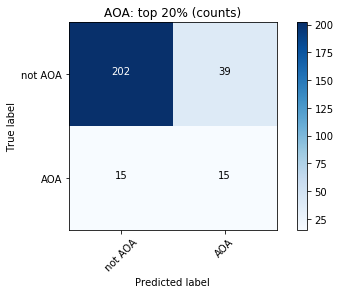

In [26]:
# Compute confusion matrix
class_names = ['not AOA', 'AOA']

labels = ['.50 threshold', 'top {}%'.format(percentages[0]), 'top {}%'.format(percentages[1])]
plots = zip([hard_predictions, hard_predictions_t1, hard_predictions_t2], labels)
title = class_names[1]

# Plot confusion matrix with counts
for predictions, label in plots:
    plt.figure()
    reporting.build_confusion_matrix(
    test.outcome, predictions, 
    class_names, 
    '{}: {}'.format(title, label))

plt.show()

In [34]:
forest = pipeline_tools.extract_model_from_pipeline(grid_search)
print(type(forest))

<class 'sklearn.ensemble.forest.RandomForestClassifier'>


In [35]:
transformed_columns = pipeline_tools.get_transformed_columns(grid_search)

In [37]:
importances, std, indices = reporting.compute_feature_importances_ensemble(
    forest, transformed_columns)

1: race_White = 0.077
2: bcpm_gpa_cumulative = 0.052
3: total_gpa_cumulative = 0.048
4: median_income_zipcode = 0.047
5: bcpm_hours_cumulative = 0.045
6: bio_percentile = 0.043
7: phy_chem_percentile = 0.042
8: num_schools_accepted_to = 0.039
9: total_percentile = 0.033
10: biol_b_counts = 0.033
11: biol_a_counts = 0.031
12: chem_a_counts = 0.031
13: exp_athletics_1.0 = 0.030
14: bcpm_b_counts = 0.029
15: parent_edu_score = 0.027
16: bcpm_a_counts = 0.025
17: bcpm_hours_postbac = 0.024
18: age_at_application = 0.020
19: math_a_counts = 0.018
20: chem_b_counts = 0.017
21: phys_a_counts = 0.017
22: race_Chinese = 0.016
23: bcpm_c_counts = 0.013
24: bcmp_gpa_juni_higher_1.0 = 0.012
25: phys_b_counts = 0.012
26: total_gpa_juni_higher_1.0 = 0.011
27: appl_year_2011.0 = 0.010
28: bcmp_gpa_soph_higher_1.0 = 0.010
29: math_b_counts = 0.009
30: bcpm_gpa_postbac = 0.008
31: chem_c_counts = 0.008
32: bcmp_gpa_seni_higher_1.0 = 0.007
33: bcmp_gpa_juni_higher_nan = 0.007
34: total_gpa_seni_higher_n

In [38]:
importances

array([  5.20e-02,   4.52e-02,   4.82e-02,   7.95e-03,   2.41e-02,
         6.25e-03,   2.50e-02,   2.92e-02,   1.27e-02,   0.00e+00,
         0.00e+00,   1.78e-02,   9.38e-03,   2.00e-03,   0.00e+00,
         3.14e-02,   3.34e-02,   3.13e-03,   0.00e+00,   0.00e+00,
         3.09e-02,   1.74e-02,   7.53e-03,   0.00e+00,   1.70e-02,
         1.21e-02,   6.54e-04,   3.35e-02,   4.32e-02,   4.17e-02,
         3.98e-03,   2.73e-02,   4.72e-02,   2.02e-02,   3.95e-02,
         4.21e-03,   4.38e-03,   4.18e-03,   3.11e-03,   1.03e-02,
         6.20e-03,   3.51e-03,   5.76e-03,   1.16e-03,   1.12e-02,
         1.81e-03,   4.11e-03,   7.28e-03,   9.93e-03,   3.23e-03,
         1.24e-02,   7.42e-03,   7.49e-03,   3.80e-03,   5.19e-03,
         2.48e-03,   3.50e-04,   7.09e-03,   6.89e-03,   2.43e-03,
         4.42e-03,   2.40e-03,   2.50e-03,   5.76e-05,   4.24e-03,
         3.28e-03,   1.59e-02,   2.54e-05,   0.00e+00,   2.67e-03,
         4.47e-03,   2.95e-03,   3.34e-03,   0.00e+00,   0.00e

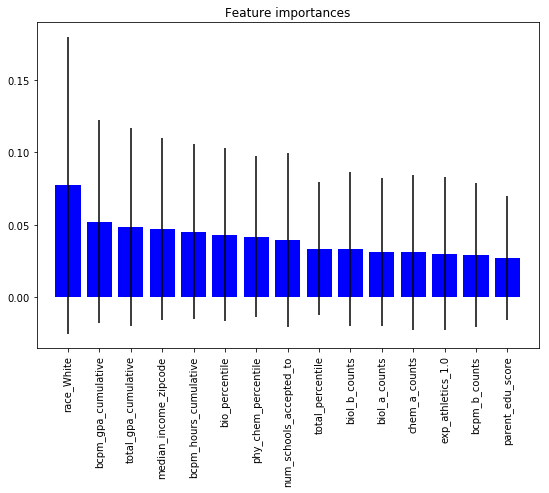

In [39]:
# Plot the feature importances of the forest
plt.figure(figsize=(9,6))
reporting.plot_feature_importances(
    importances, std, indices, transformed_columns)

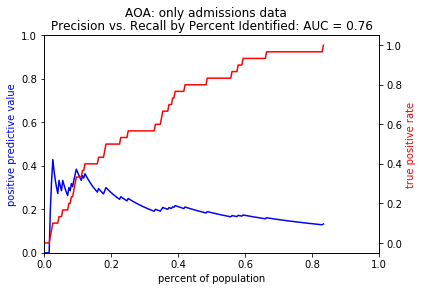

In [41]:
outcome = 'AOA'
features = 'only admissions data'
reporting.plot_precision_recall_n(test.outcome, risk_scores, '{}: {}'.format(outcome, features))

In [ ]:
# TODO: Figure out how to output to database
# TODO: Figure out sklearn2pmml
# TODO: Multiclass classification
# TODO: Compare classifiers (logistic regression?)
# TODO: Incorporate lime
# TODO: Incorporate autosklearn?